In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

toload = [ 
    dict(name="pressure_default", id="fscol1b-evpress_base_default", guard_replace = False, unnormalise = True),
    # dict(name="pressure_multispecies", id="fscol1c-evpress_base_multispecies", guard_replace = False, unnormalise = True),
    # dict(name="pressure_braginskii_afn", id="fscol1d-evpress_braginskii_afn", guard_replace = False, unnormalise = True),
    
    # dict(name="energy_default", id="fscol2-base_evolve_energy", guard_replace = False, unnormalise = True),
    # dict(name="selcoll_afnbraginskii", id="scx2-1drecycling_selcoll_afnbraginskii", guard_replace = False, unnormalise = True),
]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])
    cs[case["name"]].ds.load()

Skipping unnormalisation


In [3]:
cs["pressure_default"].ds.data_vars

Data variables:
    Bxy                            (pos) float64 3kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Ed+_iz                         (t, pos) float64 165kB 0.0 2.459e+04 ... 0.0
    Ed+_rec                        (t, pos) float64 165kB -0.0 ... -0.0
    Ed_target_recycle              (t, pos) float64 165kB 0.0 0.0 ... 0.0 0.0
    Edd+_cx                        (t, pos) float64 165kB nan 3.7 ... nan
    Fd+_iz                         (t, pos) float64 165kB 0.0 -3.518e-08 ... 0.0
    Fd+_rec                        (t, pos) float64 165kB -0.0 0.05852 ... -0.0
    Fdd+_cx                        (t, pos) float64 165kB nan -3.579e-09 ... nan
    G1                             (pos) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    G2                             (pos) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    G3                             (pos) float64 3kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    J                              (pos) float64 3kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Kd+_cond                     

# Collisions check

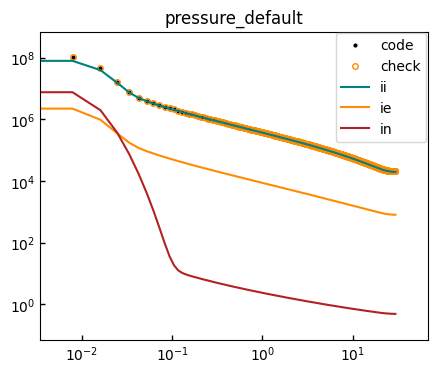

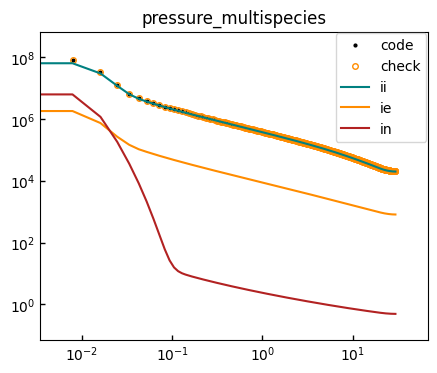

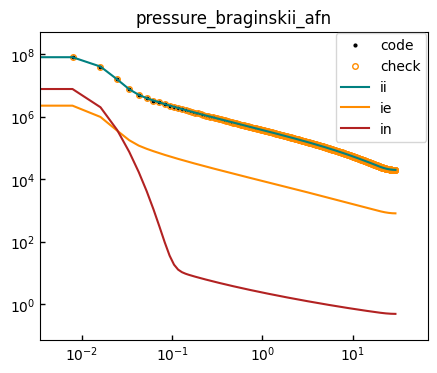

In [14]:
for name in cs.keys():

    ds = cs[name].ds.isel(pos = slice(2,-2))
    ds.data_vars

    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    m = ds.metadata

    Ta = ds["Td"].values
    Ti = ds["Td+"].values
    Te = ds["Te"].values
    Tn = ds["Td"].values
    Ne = ds["Ne"].values
    # Dn = ds["Dd_Dpar"].values

    nt = NeutralTransport(ds, dict(Te = ds["Te"], Ta = ds["Td"], Ti = ds["Td+"], Ne = ds["Ne"], Na = ds["Nd"]))
    nt.get_rates()


    Kcoll = ds["Kd+_cond"]

    Kcx = ds["Kdd+_cx"]*ds["Nd"] / ds["Nd+"]

    Kcoll_check_all = dict(
        default = ds["Kd+d+_coll"] + ds["Kd+e_coll"] + ds["Kd+d_coll"] + Kcx,
        multispecies = ds["Kd+d+_coll"] + ds["Kd+e_coll"] + ds["Kd+d_coll"] + Kcx,
        braginskii_afn = ds["Kd+d+_coll"],
    )
    
    for key in Kcoll_check_all.keys():
        if key in name:
            Kcoll_check = Kcoll_check_all[key]
            break

    fig, ax = plt.subplots(dpi = 100)
    ax.set_title(name)
    x = ds["pos"][-1] - ds["pos"]
    ax.plot(x, Kcoll, marker = "o", ms = 2, lw = 0, label = "code", c = "k")
    ax.plot(x, Kcoll_check, marker = "o", markerfacecolor = "None",  c = "darkorange", lw = 0, ms = 4, label = "check")
    
    ax.plot(x, ds["Kd+d+_coll"], label = "ii")
    ax.plot(x, ds["Kd+e_coll"], label = "ie")
    ax.plot(x, ds["Kd+d_coll"], label = "in")
    
    ax.set_yscale("log")
    ax.set_xscale("log")

    ax.set_yscale("log")
    ax.legend()
    # ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
    ax.set_xscale("log")
    # ax.set_xlim(-0.01,0.2)

# Case comparison

In [3]:
%matplotlib inline

/home/mike/work/sdtools/hermes3/plotting.py:756: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


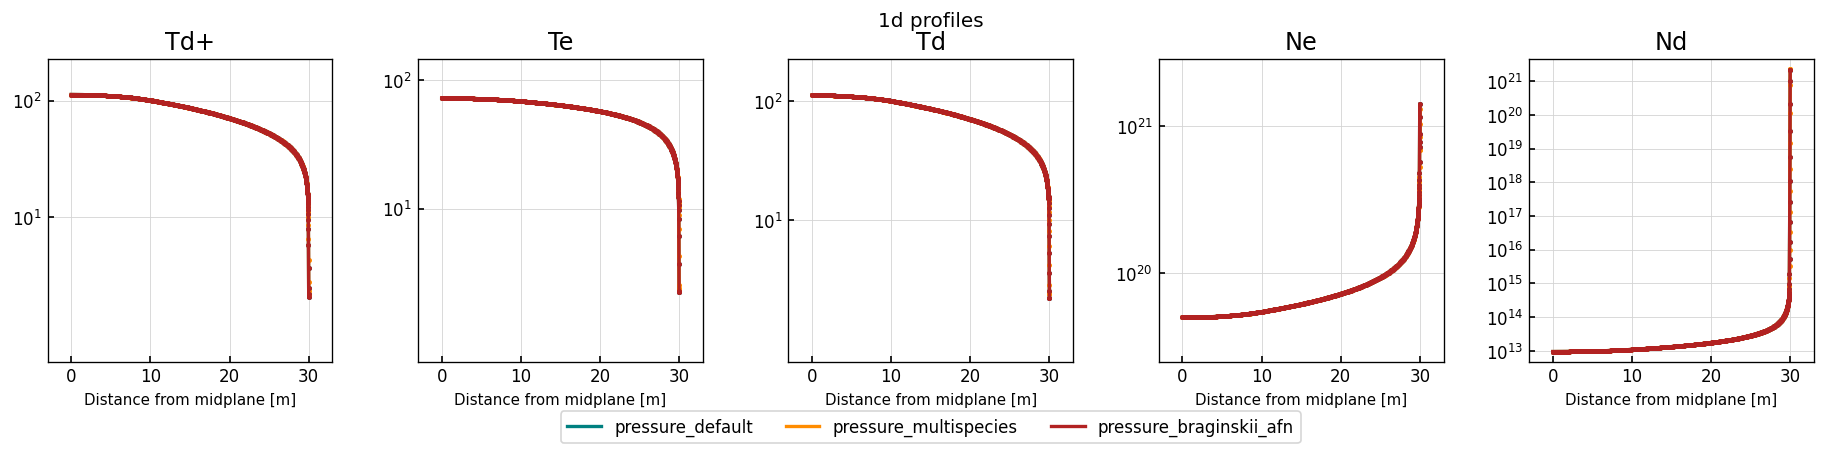

In [12]:
toplot = {}
for name in cs:
# for name in ["diags"]:
    ds = cs[name].ds
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    toplot[name] = ds

lineplot(
    toplot,
    clean_guards = False,
    params = ["Td+", "Te", "Td", "Ne", "Nd",
            #   "ParticleFlow_d+_ylow"
              ],
    # params = ["Td"],
    regions = ["1d"],
    # xlims=(9.5,10.1),
    # xlims=(29.8, 30.05 ),
    guard_replace = True
    # xlims=(0,1)
)

# Performance

In [5]:
plot_cvode_performance(cs)

TypeError: argument of type 'Case' is not iterable

# Convergence

In [9]:
cs.keys()

dict_keys(['base_master'])

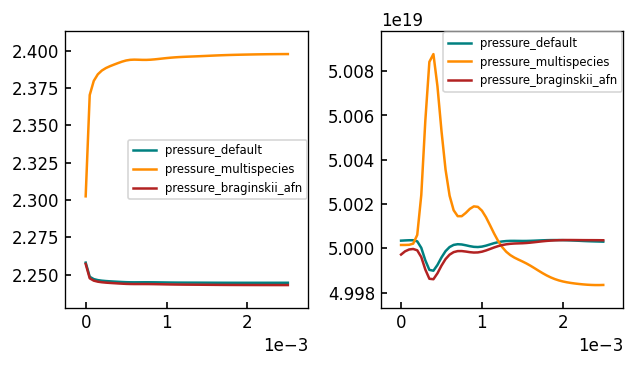

In [25]:
fig, axes = plt.subplots(1,2, figsize = (6,3), dpi = 120)

for case in cs.keys():
    ds = cs[case].ds
    t = ds["t"] - ds["t"].isel(t=0)
    axes[0].plot(t, ds["Te"].isel(pos = -3), label = case)
    axes[1].plot(t, ds["Ne"].isel(pos = 2), label = case)
    
for ax in axes:
    ax.legend(fontsize = "x-small")
fig.subplots_adjust(wspace=0.3)

/home/mike/work/sdtools/hermes3/plotting.py:756: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


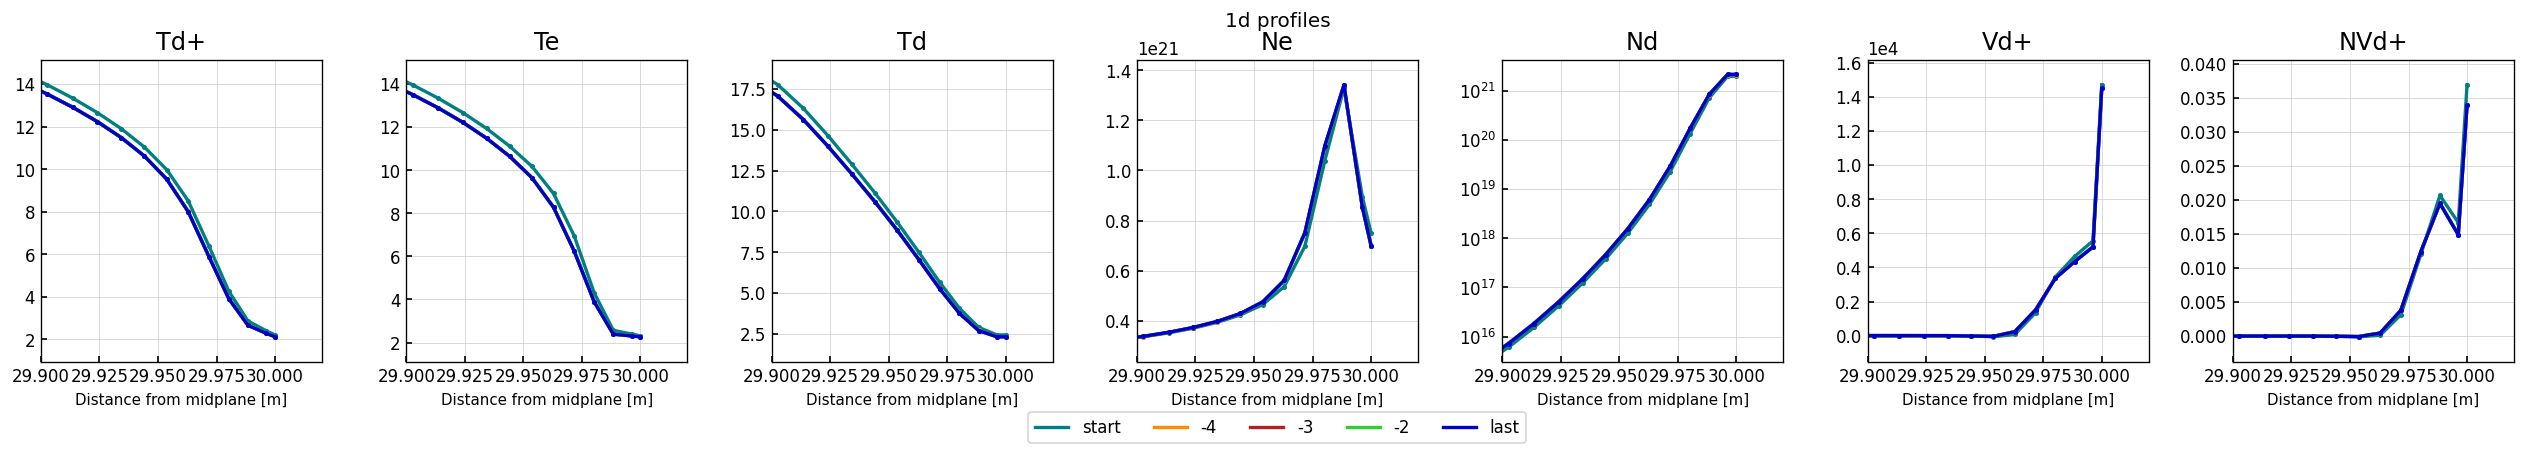

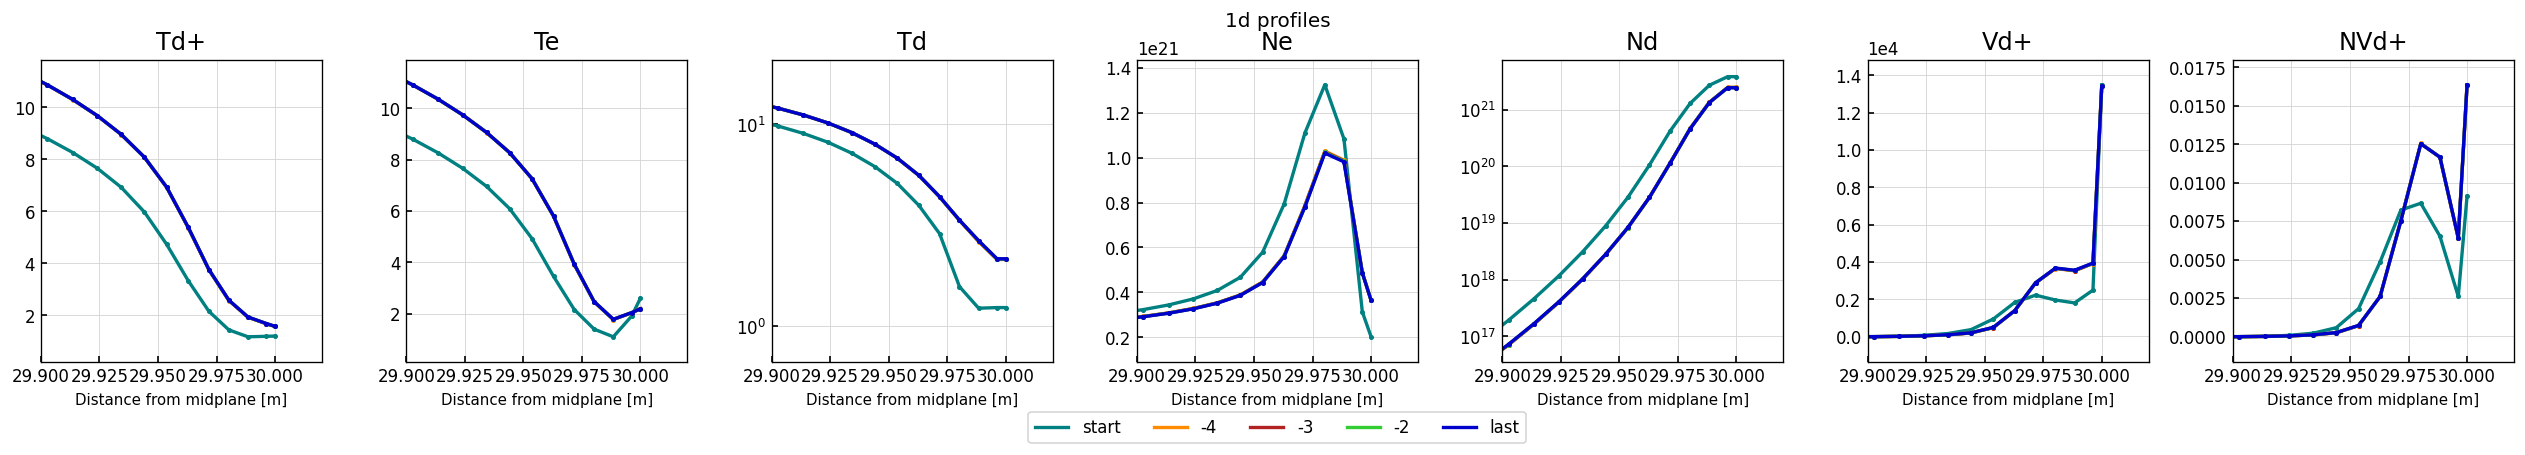

In [11]:
case = "ev_e"

for case in cs.keys():

    lineplot(
        {
            "start":cs[case].ds.isel(t=0),
            "-4":cs[case].ds.isel(t=-4),
            "-3":cs[case].ds.isel(t=-3),
            "-2":cs[case].ds.isel(t=-2),
            "last":cs[case].ds.isel(t=-1),

        },
        clean_guards = False,
        guard_replace = True,
        params = ["Td+", "Te", "Td", "Ne", "Nd", "Vd+", "NVd+"],
        regions = ["1d"],
        lw = 2,
        # markersize = 0,
        xlims = (29.9, 30.02)
        # xlims = (15, 30.02)
        # xlims = (0,1)
    )